In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of cvqa.models failed: Traceback (most recent call last):
  File "/Users/urisherman/.pyenv/versions/3.8.1/envs/curriculum_vqa/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/urisherman/.pyenv/versions/3.8.1/envs/curriculum_vqa/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/urisherman/.pyenv/versions/3.8.1/envs/curriculum_vqa/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/urisherman/.pyenv/versions/3.8.1/envs/curriculum_vqa/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/urisherman/.pyenv/versions/3.8.1/envs/curriculum_vqa/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic


In [ ]:
output

In [2]:
import sys
import os

%load_ext tensorboard

_include_('curriculum_vqa')
_include_('commons')

data_bin = f'{DEV_HOME}/curriculum_vqa/data-bin'

In [3]:
from cvqa import datasets, models, trainers, viz

In [4]:
train_dataset = datasets.BasicCurriculum(f'{data_bin}/basic_curriculum', 'train', limit=100)
dev_dataset = datasets.BasicCurriculum(f'{data_bin}/basic_curriculum', 'dev', limit=10)
train_dataset

Root: /Users/urisherman/Work/workspace/curriculum_vqa/data-bin/basic_curriculum/train 
Samples: 102 (N_prompt=1, N_target=1)
Concepts: 2 
Classes: 5 
Vocab Tokens:8

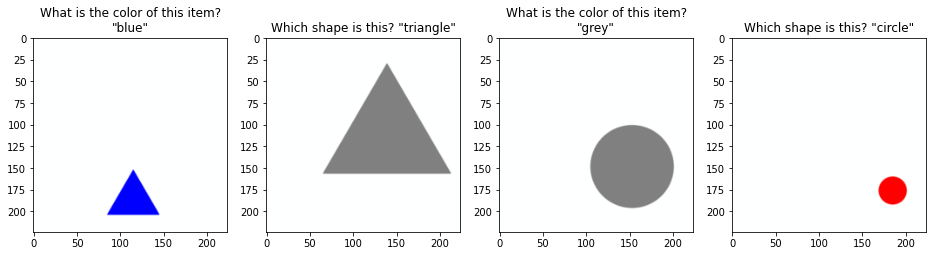

In [5]:
viz.show_samples(train_dataset)

In [8]:
import logging
import statistics
import os
import warnings

from datetime import datetime

import torch
import torch.utils as torch_utils
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter

import fairseq.utils as fairseq_utils

from tqdm import tqdm

from cvqa import datasets, utils, models, viz
from cvqa import fairseq_misc


In [96]:
params = {
    'd': 16
}

vocab = train_dataset.vocab
tokens_embeddings = fairseq_misc.build_embedding(vocab, params['d'])
tokens_embeddings

Embedding(8, 16, padding_idx=1)

In [97]:
decoder = models.build_decoder(vocab, tokens_embeddings, d=params['d'])

In [102]:
from fairseq.models.transformer import TransformerModel, TransformerEncoder, TransformerDecoder, EncoderOut

B = 2
N_prompt = 7
F_img = 8

prompt_embedding = torch.rand(B, N_prompt, params['d'])
prompt_pad_mask = prompt_embedding.sum(axis=-1) == 0
img_embedding = torch.rand(B, F_img, params['d'])

prev_decoded_tokens = torch.randint(3, [B, 1])

decoder_out = decoder(prompt_embedding, prompt_pad_mask, img_embedding, prev_decoded_tokens)
decoder_out

(tensor([[[ 0.4175,  0.0000,  1.7619,  0.2088, -1.9299,  0.4869,  0.7468,
            0.9934]],
 
         [[-0.0863,  0.0000,  1.6493, -0.4398, -0.1533, -0.5381,  0.7553,
            0.2950]]], grad_fn=<UnsafeViewBackward>),
 {'attn': tensor([[[0.0668, 0.0648, 0.0636, 0.0708, 0.0704, 0.0787, 0.0587, 0.0618,
            0.0694, 0.0656, 0.0629, 0.0703, 0.0571, 0.0635, 0.0757]],
  
          [[0.0760, 0.0716, 0.0545, 0.0674, 0.0757, 0.0624, 0.0766, 0.0676,
            0.0657, 0.0635, 0.0582, 0.0636, 0.0655, 0.0687, 0.0629]]],
         grad_fn=<MeanBackward1>),
  'inner_states': [tensor([[[-0.0000,  0.5294,  1.7023, -1.7081,  2.4041, -0.3990, -0.1208,
              0.6410, -0.1022,  3.4557, -1.1689,  0.0000,  2.1475,  0.0000,
              2.3755,  0.0000],
            [-0.1018,  0.0000,  1.7023, -1.7081,  2.4041, -0.0000, -0.1208,
              0.6410, -0.1022,  3.4557, -0.0000,  0.0000,  0.0000,  0.0000,
              2.3755,  0.7372]]], grad_fn=<TransposeBackward0>),
   tensor([[[-0.41

In [87]:
decoder_in = EncoderOut(
    encoder_out=comodal_embedding.transpose(0, 1),  # N_in x B x d
    encoder_padding_mask=comodal_pad_mask,  # B x N_in
    encoder_embedding=None,  # B x N_in x d
    encoder_states=[],  # List[N_in x B x d]
)

prev_decoded_tokens = torch.randint(3, [B, 1])
decoder_out = decoder(prev_decoded_tokens, encoder_out=decoder_in)
decoder_out

(tensor([[[ 0.6834,  0.0000,  0.1041, -2.0013, -0.5447,  0.8567, -1.4483,
           -0.9313]],
 
         [[ 0.8919,  0.0000,  0.0195, -1.2111, -0.2487,  0.3516, -0.2654,
           -0.6239]]], grad_fn=<UnsafeViewBackward>),
 {'attn': tensor([[[0.0676, 0.0786, 0.0649, 0.0648, 0.0634, 0.0618, 0.0708, 0.0536,
            0.0770, 0.0541, 0.0710, 0.0737, 0.0647, 0.0667, 0.0673]],
  
          [[0.0618, 0.0587, 0.0653, 0.0653, 0.0699, 0.0672, 0.0580, 0.0640,
            0.0702, 0.0713, 0.0810, 0.0798, 0.0572, 0.0614, 0.0688]]],
         grad_fn=<MeanBackward1>),
  'inner_states': [tensor([[[-0.0000,  0.4043,  0.0000,  0.0000, -1.2167, -1.9242,  1.8285,
              0.0000,  0.8778,  2.0578,  1.9187,  1.5122,  2.3806,  2.0839,
              0.6163,  2.9395],
            [-0.0000,  0.4043,  1.0425,  0.0000, -1.2167, -0.0000,  1.8285,
              2.7819,  0.8778,  2.0578,  1.9187,  0.0000,  0.0000,  2.0839,
              0.6163,  2.9395]]], grad_fn=<TransposeBackward0>),
   tensor([[[-0.36

In [77]:
prompt_embedding

tensor([[[0.4837, 0.9220, 0.9818, 0.8079, 0.2025, 0.4406, 0.7419, 0.0560,
          0.0627, 0.8325, 0.0907, 0.4669, 0.5580, 0.0814, 0.2719, 0.3726],
         [0.2622, 0.7644, 0.9296, 0.4638, 0.6483, 0.5691, 0.3506, 0.3497,
          0.5004, 0.9749, 0.5271, 0.4078, 0.1193, 0.0726, 0.0152, 0.1966],
         [0.7961, 0.5996, 0.9392, 0.6957, 0.9868, 0.2549, 0.6888, 0.4651,
          0.3771, 0.0369, 0.4301, 0.2792, 0.1685, 0.7594, 0.1309, 0.8572],
         [0.3026, 0.5476, 0.7991, 0.5769, 0.3314, 0.1503, 0.2420, 0.3108,
          0.9997, 0.1848, 0.3946, 0.1533, 0.2218, 0.4395, 0.7386, 0.8897],
         [0.2848, 0.6593, 0.3145, 0.2421, 0.4646, 0.4172, 0.9467, 0.9588,
          0.9815, 0.9677, 0.7327, 0.8112, 0.3317, 0.0706, 0.6285, 0.3173],
         [0.0608, 0.6005, 0.2541, 0.6193, 0.7896, 0.8672, 0.6473, 0.9345,
          0.8886, 0.8783, 0.6411, 0.9486, 0.9124, 0.2591, 0.4121, 0.3241],
         [0.3418, 0.8317, 0.7795, 0.0040, 0.9763, 0.0627, 0.5438, 0.5866,
          0.7597, 0.4066, 0.3171

In [40]:
prompt_embedding.transpose(0, 1).shape

torch.Size([7, 2, 12])

In [ ]:
dims = {
    'p': 7,  # perception embedding dim
    'V': token_embeddings.num_embeddings, 
    'd': token_embeddings.embedding_dim
}

decoder_layer = nn.TransformerDecoderLayer(d_model=dims['d'], nhead=1)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
memory = torch.rand(10, 32, 512)
target = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)

In [ ]:
class VQAPromptOpModel(nn.Module):

    @staticmethod
    def build(d, dataset, c=None, img_perceptor=None):
        prompt_embeddings, target_embeddings = build_embeddings(d, dataset, c=c)
        return VQAPromptOpModel(prompt_embeddings, target_embeddings, img_perceptor=img_perceptor)

    def __init__(self, prompt_embedding, target_embedding, img_perceptor=None):
        super().__init__()

        if img_perceptor is None:
            img_perceptor = BasicImgModel(20)
        self.img_perceptor = img_perceptor
        img_embedding = img_perceptor(torch.rand(1, 3, 224, 224))
        B, P = img_embedding.shape

        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        dims = {
            'P': P,  # perception embedding dim
            'V': prompt_embedding.num_embeddings,  # num of prompt tokens
            'd': prompt_embedding.embedding_dim,  # prompt tokens embedding
            'L': target_embedding.num_embeddings,  # num of target toekns
            'c': target_embedding.embedding_dim  # target tokens embedding
        }
        self.dims = dims
        self.prompt_embedding = prompt_embedding
        self.target_embedding = target_embedding

        # The operators operator
        # Given an embedded prompt, output a P --> c operator
        self.W_op = nn.Parameter(torch.Tensor(dims['d'], dims['P'], dims['c']))
        nn.init.kaiming_uniform_(self.W_op, a=math.sqrt(5))

        self.layer_norm = nn.LayerNorm([dims['c']])

    def forward(self, prompt, img):
        if len(prompt.shape) == 1:
            prompt = prompt.view(-1, 1)
        prompt_encoded = self.prompt_embedding(prompt)  # [B x N_prompt x d]
        prompt_encoded = torch.sum(prompt_encoded, dim=1)  # [B x d]
        prompts_ops = torch.einsum('bd,dpc->bpc', prompt_encoded, self.W_op)  # [B x P x c]

        img_features = self.img_perceptor(img)  # [B, P]

        # pred_embeded = F.linear(img_features, prompt_op.T)  # [B, c]
        pred_embeded = torch.einsum('bp,bpc->bc', img_features, prompts_ops) # [B, c]

        pred_embeded = self.layer_norm(pred_embeded)

        t_embeddings = self.target_embedding.weight
        logits = pred_embeded @ t_embeddings.T
        return logits

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

viz_model = models.VQAPromptOpModel.build(d=2, dataset=train_dataset, c=5)

optimizer = torch.optim.Adam(viz_model.parameters(), lr=1e-3)

my_trainer = trainers.ImageClassifierTrainer()
train_loss, train_acc, dev_acc = my_trainer.train(
    viz_model, train_dataset, dev_dataset, 
    optimizer, num_epochs=3, batch_size=32
)

[epoch=0, train_acc=0.10, dev_acc=0.00] loss: 2.590: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]
[epoch=1, train_acc=0.24, dev_acc=0.00] loss: 2.350: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]
[epoch=2, train_acc=0.24, dev_acc=0.00] loss: 2.109: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


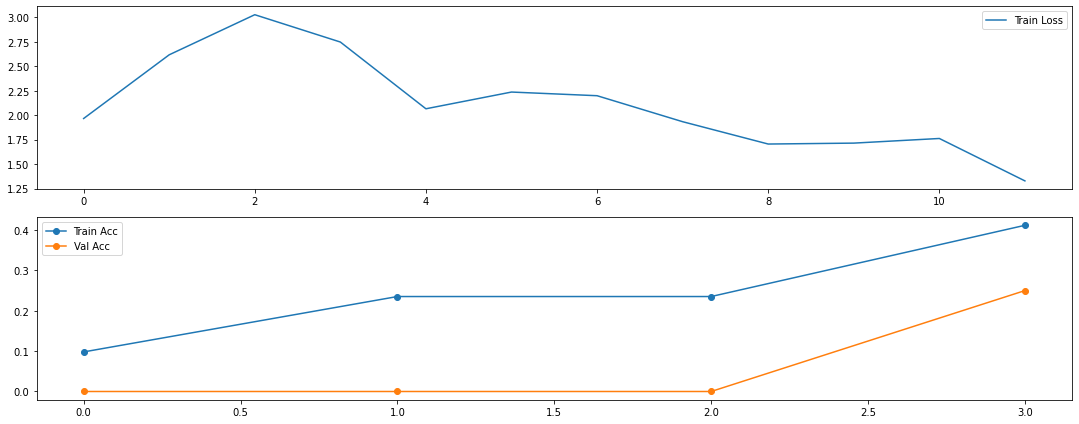

In [7]:
viz.plot_training(train_loss, train_acc, dev_acc)

Which shape is this?
True: triangle
Pred: triangle


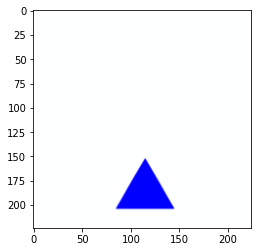

In [8]:
viz.test_sample(viz_model, train_dataset, sample_idx=2)

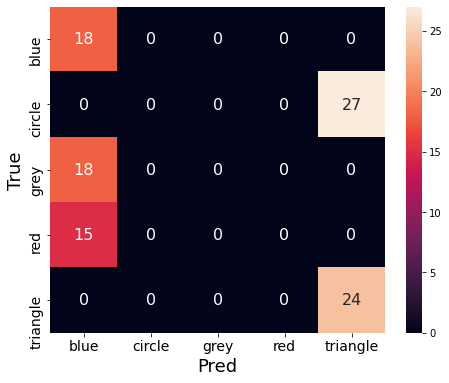

In [9]:
eval_res = my_trainer.get_predictions(viz_model, train_dataset).numpy()

y_true = eval_res[:, 1]
y_pred = eval_res[:, 2]
labels = list(train_dataset.cls_to_idx.keys())

viz.plot_conf_mat(y_true, y_pred, labels)